# Gender Bias Recruitment - Model Biased

Este notebook treina modelos de Machine Learning usando o **dataset enviesado** (`2025-fairness-recruitment-dataset.csv`).  
O objetivo é **simular como um modelo aprende vieses humanos**, avaliando métricas gerais e fairness.

Antes de iniciar, certifique-se de ter instalado as dependências necessárias usando o comando: 
`pip install -r requirements.txt`

## 1. Importação das bibliotecas

Importamos bibliotecas para:
- Interação com o sistema de arquivos (`os`, `sys`)
- Manipulação e análise de dados (`pandas`, `numpy`)
- Visualização (`matplotlib`, `seaborn`)
- Carregamento de objetos salvos (`pickle`)
- Módulos personalizados do `src/` para pré-processamento, treino e fairness
- Configuração do estilo visual com `sns.set(style="whitegrid")`

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_preprocessing import load_dataset, clean_columns, encode_categorical, split_features_target, train_test_split_stratified
from fairness_metrics import remove_sensitive_attributes, compute_fairness_metrics
from train_model import train_and_evaluate, save_object

# Configurações visuais
sns.set(style="whitegrid")

## 2. Carregamento do dataset enviesado

Aqui carregamos o CSV `2025-fairness-recruitment-dataset.csv` usando a função `load_dataset()` e padronizamos os nomes das colunas com `clean_columns()`.  
Isso garante consistência nos nomes e facilita o pré-processamento.

In [2]:
df_biased = load_dataset("../data/2025-fairness-recruitment-dataset.csv")
df_biased = clean_columns(df_biased)
df_biased.head()

,mainid_hidden,mod15_hidden,div15_hidden,Age_feature_sensitive,Speed_hidden,Gender_feature_sensitive,Strength_hidden,Speedtest_hidden,Lifttest_hidden,testresult_feature,...,Suitability_target,Value-when-hired_hidden,Candidate-loss-when-nothired_hidden,Should-hire_target,Shouldnothire,hired-by-expert,A1_testresult,A2_testresult_30under,A3_Age_Gender_test,A4_postive-dicr
0,225000,0,0,22,2,male,6,1.0,1.0,2.0,...,4,"10,000",5000,1,0,1,1,1,1,1
1,225001,1,0,26,2,male,6,0.5,1.0,1.5,...,4,"10,000",5000,1,0,1,1,1,1,0
2,225002,2,0,28,1,male,6,1.0,1.0,2.0,...,3,"5,000",5000,1,0,1,1,1,1,1
3,225003,3,0,28,1,male,6,0.5,1.0,1.5,...,3,"5,000",5000,1,0,1,1,1,1,0
4,225004,4,0,32,2,male,6,1.0,1.0,2.0,...,4,"10,000",5000,1,0,1,1,1,1,1


## 3. Pré-processamento

- Convertendo variáveis categóricas para numéricas usando `encode_categorical()`.
- Separando as features da variável alvo (`Should-hire_target`) com `split_features_target()`.
- Dividindo os dados em treino e teste, mantendo a proporção da variável alvo (stratified split).

In [ ]:
# identificar a coluna target
target_col = "Should-hire_target"

# encode todas as categóricas
df_biased, le_dict = encode_categorical(df_biased)

# separar features e target
X, y = split_features_target(df_biased, target_col)

# dividir em treino/teste mantendo proporção
X_train, X_test, y_train, y_test = train_test_split_stratified(X, y)

print(f"Treino: {X_train.shape} | Teste: {X_test.shape}")

gender_map = {0: "male", 1: "female"}
X_test_gender_label = X_test['Gender_feature_sensitive'].map(gender_map)

Treino: (157, 20) | Teste: (68, 20)


## 4. Treinamento e avaliação do modelo enviesado

Vamos treinar:
- Treinamos **Logistic Regression** e **Random Forest**.- 
- Avaliamos métricas gerais (accuracy, precision, recall, f1-score).
- Avaliamos fairness por gênero usando métricas de Demographic Parity, Equal Opportunity e Disparate Impact.

In [4]:
# Coluna sensível
sensitive_col = "Gender_feature_sensitive"

# Treinar e avaliar Regressão Logística
print("### Logistic Regression ###")
model_lr, y_pred_lr, metrics_lr = train_and_evaluate(
    X_train, X_test, y_train, y_test, 
    model_type="logistic", sensitive_col=sensitive_col
)

df_group_lr, summary_lr = compute_fairness_metrics(
    model=model_lr,
    X=X_test,
    y_true=y_test,
    sensitive_series=X_test[sensitive_col]
)

### Logistic Regression ###
===== MODEL METRICS =====
accuracy: 1.00
precision: 1.00
recall: 1.00
f1_score: 1.00

===== FAIRNESS EVALUATION (Sensitive: Gender_feature_sensitive) =====
===== Fairness por grupo =====
       support  positive_rate  TPR  FPR  FNR
group                                       
0           27       0.185185  1.0  0.0  0.0
1           41       0.439024  1.0  0.0  0.0


In [5]:
# Treinar e avaliar Random Forest
print("### Random Forest ###")
model_rf, y_pred_rf, metrics_rf = train_and_evaluate(
    X_train, X_test, y_train, y_test, 
    model_type="rf", sensitive_col=sensitive_col
)

df_group_rf, summary_rf = compute_fairness_metrics(
    model=model_rf,
    X=X_test,
    y_true=y_test,
    sensitive_series=X_test[sensitive_col]
)

### Random Forest ###
===== MODEL METRICS =====
accuracy: 1.00
precision: 1.00
recall: 1.00
f1_score: 1.00

===== FAIRNESS EVALUATION (Sensitive: Gender_feature_sensitive) =====
===== Fairness por grupo =====
       support  positive_rate  TPR  FPR  FNR
group                                       
0           27       0.185185  1.0  0.0  0.0
1           41       0.439024  1.0  0.0  0.0


## 5. Visualização da decisão por gênero

Aqui mostramos a **taxa de contratação prevista por gênero**, comparando como os modelos reproduzem o viés humano.

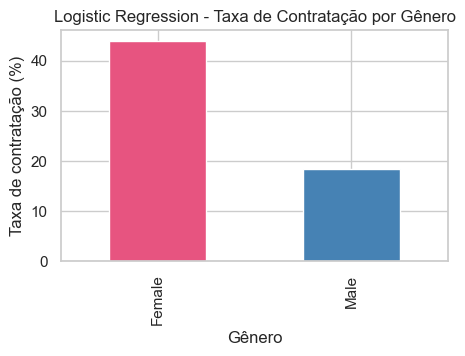

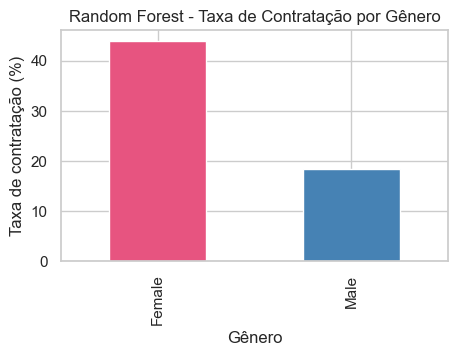

In [6]:
def plot_hire_rate(y_pred, sensitive_attr, title="Taxa de Contratação Prevista por Gênero"):
    df_plot = pd.DataFrame({
        "prediction": y_pred,
        "gender": sensitive_attr
    })
    hire_rate = df_plot.groupby("gender")["prediction"].mean() * 100
    hire_rate.plot(kind="bar", color=["#E75480", "#4682B4"], figsize=(5,3))
    plt.title(title)
    plt.ylabel("Taxa de contratação (%)")
    plt.xlabel("Gênero")
    plt.show()

# Logistic Regression
plot_hire_rate(y_pred_lr, X_test_gender_label, title="Logistic Regression - Taxa de Contratação por Gênero")

# Random Forest
plot_hire_rate(y_pred_rf, X_test_gender_label, title="Random Forest - Taxa de Contratação por Gênero")

## 6. Salvando métricas e modelos treinados

Após treinar e avaliar os modelos, salvamos os objetos de métricas e os modelos em arquivos `.pkl`.  

In [7]:
# Salvar métricas e fairness do modelo LR
save_object(metrics_lr, "metrics_lr.pkl")
save_object(df_group_lr, "df_group_lr.pkl")
save_object(summary_lr, "summary_lr.pkl")

# Salvar métricas e fairness do modelo RF
save_object(metrics_rf, "metrics_rf.pkl")
save_object(df_group_rf, "df_group_rf.pkl")
save_object(summary_rf, "summary_rf.pkl")

## 7. Conclusões parciais

- Observamos como os modelos reproduzem o viés presente nos dados humanos.  
- Comparando as taxas de contratação por gênero, podemos quantificar o viés aprendido pelo modelo.  
- Esses resultados serão usados como **baseline enviesada**, para comparar com o modelo fair do próximo notebook.